<a href="https://colab.research.google.com/github/atick-faisal/Crowd-Emotion/blob/main/src_v4/CE_TE_YAMNET_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow_io

In [2]:
import os
import time
import json
import datetime

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

from sklearn.metrics import classification_report

tf.random.set_seed(42)

tf.__version__

'2.4.1'

In [3]:
CONFIG = {
    'timestamp'             : str(datetime.datetime.now()),
    'model'                 : 'Transfer Learning on YAMNET',
    'test_fold'             : 'Fold 1',
    'architecture'          : '',
    'batch_size'            : 32,
    'epochs'                : 0,
    'learning_rate'         : 0.000001,
    'patience'              : 2,
    'training_time'         : 0,
    'testing_time'          : 0,
    'cm_atick'              : '',
    'cr_atick'              : '',
    'cm_valentina'          : '',
    'cr_valentina'          : ''
}

In [4]:
BASE_DIR            = os.getcwd()
LOG_FILE             = '/content/drive/MyDrive/Research/Crowd Emotion Logs/tl_yamnet.txt'
FOLDS               = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
EMOTIONS            = ['Approval', 'Disapproval', 'Neutral']

ATICK_DATA_DIR      = '/content/Dataset-Atick/'
VALENTINA_DATA_DIR  = '/content/Dataset-Valentina/'

In [5]:
%%time

# # ----------------- Loading my dataset -------------------
# !mkdir /content/Dataset-Atick/
# !gdown --id '1HOe5sJe_Juf5uib4f-8pPv-Z64lmqQ4X'
# !tar -xf /content/Crowd-Emotion-Dataset.tar.xz -C /content/Dataset-Atick/

# # ----------------- Loading Valentina's dataset -------------------
# !mkdir /content/Dataset-Valentina/
# !gdown --id '11tC2Nmie9v3ljo60oQJ3sN1rVkorV-N1'
# !tar -xf /content/Valentina_CE_Dataset.tar.xz -C /content/Dataset-Valentina/


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [6]:
# ------------- Load YAMNET fron TF-Hub ------------------

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [7]:
# --------------- File loading utilities ------------------

@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

def load_ds(path, class_names, fold_names=['']):

    filenames = []
    labels = []
    folds = []

    for class_name in class_names:
        print('processing files for ' + class_name, end=' ... ')

        for fold in fold_names:
            files_path = os.path.join(path, class_name, fold)

            for filename in os.listdir(files_path):
                filenames.append(os.path.join(files_path, filename))
                labels.append(class_names.index(class_name))

                try:
                    folds.append(FOLDS.index(fold))
                except ValueError:
                    folds.append(0)

        print('√')

    return tf.data.Dataset.from_tensor_slices((filenames, labels, folds))

In [8]:
atick_ds = load_ds(ATICK_DATA_DIR, EMOTIONS, FOLDS)
valentina_ds = load_ds(VALENTINA_DATA_DIR, EMOTIONS)

# atick_ds.element_spec

processing files for Approval ... √
processing files for Disapproval ... √
processing files for Neutral ... √
processing files for Approval ... √
processing files for Disapproval ... √
processing files for Neutral ... √


In [9]:
atick_ds = atick_ds.map(load_wav_for_map)
valentina_ds = valentina_ds.map(load_wav_for_map)

In [10]:
# --------- Embeddings extraction using YAMNET -------------
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (
            embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings)
)

atick_ds = atick_ds.map(extract_embedding).unbatch()
valentina_ds = valentina_ds.map(extract_embedding).unbatch()

atick_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [11]:
cached_ds_atick = atick_ds.cache()
cached_ds_valentina = valentina_ds.cache()

train_ds = cached_ds_atick.filter(
    lambda embedding, label, fold: fold != FOLDS.index(CONFIG['test_fold'])
)
val_ds = cached_ds_atick.filter(
    lambda embedding, label, fold: fold == FOLDS.index(CONFIG['test_fold'])
)

test_ds = cached_ds_valentina

# train_ds = cached_ds_atick
# val_ds = cached_ds_valentina
# test_ds = cached_ds_valentina

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000) .batch(CONFIG['batch_size']) \
                    .prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(CONFIG['batch_size']).prefetch(tf.data.AUTOTUNE)

In [12]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(EMOTIONS))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [13]:
my_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=CONFIG['patience'],
    restore_best_weights=True
)

In [14]:
%%time
start_time = time.time()

history = my_model.fit(
    train_ds,
    epochs=300,
    validation_data=val_ds,
    callbacks=callback
)

training_time = time.time() - start_time

Epoch 1/300
251/251 [==============================] - 110s 403ms/step - loss: 1.2045 - accuracy: 0.2028 - val_loss: 0.9276 - val_accuracy: 0.8515
Epoch 2/300
251/251 [==============================] - 1s 4ms/step - loss: 1.1731 - accuracy: 0.2265 - val_loss: 0.9101 - val_accuracy: 0.8871
Epoch 3/300
251/251 [==============================] - 1s 4ms/step - loss: 1.1433 - accuracy: 0.2586 - val_loss: 0.8948 - val_accuracy: 0.9001
Epoch 4/300
251/251 [==============================] - 1s 4ms/step - loss: 1.1086 - accuracy: 0.2983 - val_loss: 0.8809 - val_accuracy: 0.9032
Epoch 5/300
251/251 [==============================] - 1s 4ms/step - loss: 1.0828 - accuracy: 0.3349 - val_loss: 0.8684 - val_accuracy: 0.9062
Epoch 6/300
251/251 [==============================] - 1s 4ms/step - loss: 1.0654 - accuracy: 0.3574 - val_loss: 0.8568 - val_accuracy: 0.9108
Epoch 7/300
251/251 [==============================] - 1s 4ms/step - loss: 1.0351 - accuracy: 0.4000 - val_loss: 0.8463 - val_accuracy: 0.

<h3 align="center">RESULTS</h3>

In [15]:
%%time

# ---------------- Testing on valentina's data -------------------

start_time = time.time()

loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

testing_time = time.time() - start_time

157/157 [==============================] - 0s 2ms/step - loss: 0.5668 - accuracy: 0.8393
Loss:  0.5667849183082581
Accuracy:  0.839339017868042
CPU times: user 785 ms, sys: 29.4 ms, total: 815 ms
Wall time: 480 ms


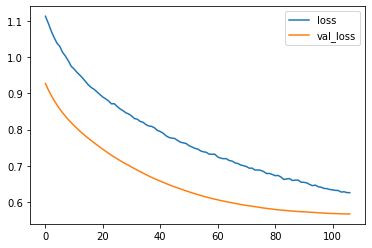

In [16]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [17]:
# ------------------ Testing on Aticks's data -----------------

test_labels = []
for _, label in val_ds:
    test_labels += (label.numpy().tolist())

y_true = np.squeeze(np.array(test_labels))
y_pred = np.argmax(my_model.predict(val_ds), axis=1)

result_atick = classification_report(y_true, y_pred)
print(result_atick)

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       973
           1       0.11      0.13      0.12       217
           2       0.98      0.85      0.91      3833

    accuracy                           0.84      5023
   macro avg       0.58      0.65      0.60      5023
weighted avg       0.88      0.84      0.85      5023



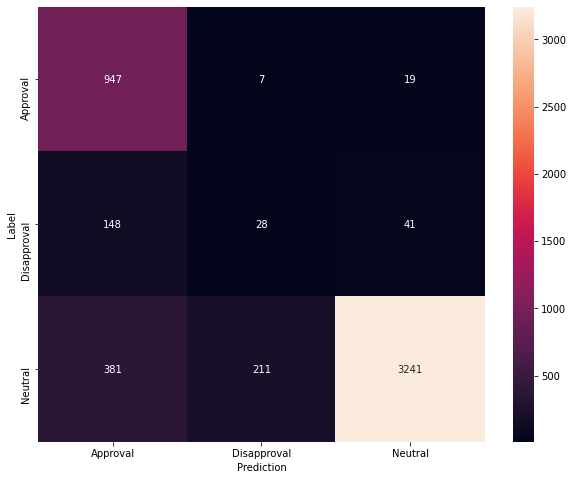

In [18]:
confusion_mtx_atick = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_atick, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [19]:
# ------------------ Testing on Valentina's data -----------------

test_labels = []
for _, label in test_ds:
    test_labels += (label.numpy().tolist())

y_true = np.squeeze(np.array(test_labels))
y_pred = np.argmax(my_model.predict(test_ds), axis=1)

result_valentina = classification_report(y_true, y_pred)
print(result_valentina)

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       973
           1       0.11      0.13      0.12       217
           2       0.98      0.85      0.91      3833

    accuracy                           0.84      5023
   macro avg       0.58      0.65      0.60      5023
weighted avg       0.88      0.84      0.85      5023



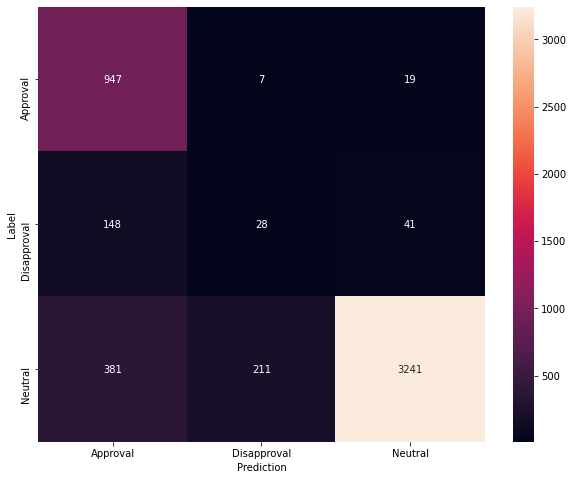

In [20]:
confusion_mtx_valentina = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_valentina, xticklabels=EMOTIONS, yticklabels=EMOTIONS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [21]:
summary = []
my_model.summary(print_fn=lambda x: summary.append(x))
CONFIG['architecture'] = summary
CONFIG['epochs'] = max(history.epoch)
CONFIG['training_time'] = training_time
CONFIG['testing_time'] = testing_time
CONFIG['cm_atick'] = np.array2string(confusion_mtx_atick.numpy())
result_list_atick = result_atick.split('\n')
CONFIG['cr_atick'] = result_list_atick
CONFIG['cm_valentina'] = np.array2string(confusion_mtx_valentina.numpy())
result_list_valentina = result_valentina.split('\n')
CONFIG['cr_valentina'] = result_list_valentina

In [22]:
config = json.dumps(CONFIG, indent=4)
print(config)

{
    "timestamp": "2021-05-07 20:28:02.700601",
    "model": "Transfer Learning on YAMNET",
    "test_fold": "Valentina",
    "architecture": [
        "Model: \"my_model\"",
        "_________________________________________________________________",
        "Layer (type)                 Output Shape              Param #   ",
        "=================================================================",
        "dense (Dense)                (None, 512)               524800    ",
        "_________________________________________________________________",
        "dropout (Dropout)            (None, 512)               0         ",
        "_________________________________________________________________",
        "dense_1 (Dense)              (None, 3)                 1539      ",
        "=================================================================",
        "Total params: 526,339",
        "Trainable params: 526,339",
        "Non-trainable params: 0",
        "_________________

In [23]:
f = open(LOG_FILE, 'a')
f.write('\n')
f.write(config)
f.write('\n')
f.close()